In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import arviz as az
import torch
import pyro
import pyro.distributions as dist
from pyro.distributions import constraints, transforms
from pyro.infer import Predictive, TracePredictive, NUTS, MCMC
from pyro.infer.autoguide import AutoLaplaceApproximation
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from patsy import dmatrix
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10, 4)

# Chapter 5 - Splines

## 5.5 - Fitting splines in Pyro

In [5]:
day = pd.read_csv('./data/Bike-Sharing-Dataset/day.csv')
hour = pd.read_csv('./data/Bike-Sharing-Dataset/hour.csv')

In [6]:
hour['cnt_std'] = hour['cnt'] / hour['cnt'].max()

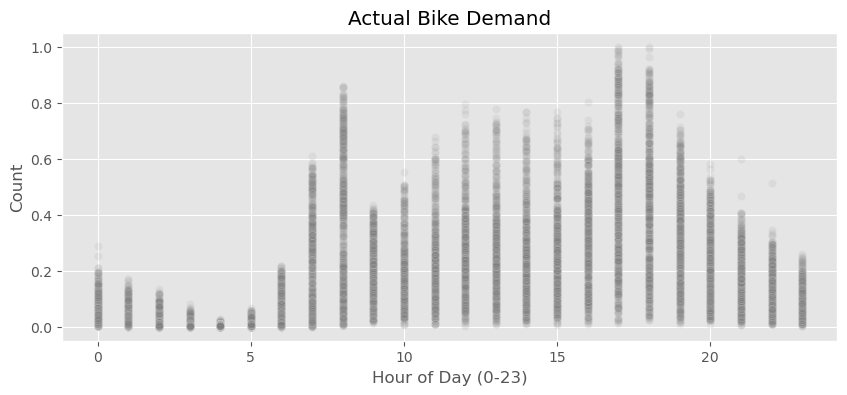

In [10]:
sns.scatterplot(x=hour['hr'], y=hour['cnt_std'], alpha=0.1, color='grey')
plt.ylabel('Count')
plt.xlabel('Hour of Day (0-23)')
plt.title('Actual Bike Demand');

In [11]:
num_knots = 6
knot_list = torch.linspace(0, 23, num_knots + 2)[1:-1]

In [12]:
B = dmatrix(
    "bs(cnt_std, knots=knots, degree=3, include_intercept=True) - 1",
    {'cnt_std': hour.hr.values, 'knots': knot_list[1:-1]}
)

B = torch.tensor(np.asarray(B)).float()
cnt_bikes = torch.tensor(hour['cnt_std'].values).float()
hour_bikes = torch.tensor(hour['hr'].values).reshape(-1, 1).float()

### MCMC

In [54]:
def splines(design_matrix, count_bikes=None):

    N, P = design_matrix.shape

    tau = pyro.sample('tau', dist.HalfCauchy(1.))
    sigma = pyro.sample('sigma', dist.HalfNormal(1.))

    with pyro.plate('knot_list', P):
        beta = pyro.sample('beta', dist.Normal(0., tau))

    mu = pyro.deterministic('mu', torch.matmul(beta, design_matrix.T))

    with pyro.plate('output', N):
        output = pyro.sample('y', dist.Normal(mu, sigma), obs=count_bikes)


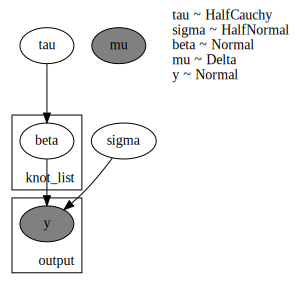

In [56]:
pyro.render_model(
    splines, (B, cnt_bikes), render_distributions=True
)

In [100]:
kernel = NUTS(splines)
mcmc_splines = MCMC(kernel, 500, 300)
mcmc_splines.run(B, cnt_bikes)

Sample: 100%|██████████| 800/800 [00:18, 42.85it/s, step size=2.28e-01, acc. prob=0.928]


In [102]:
prior_predictive = Predictive(splines, num_samples=500)(B, None)
spline_samples = mcmc_splines.get_samples(500)
splines_predictive = Predictive(splines, spline_samples)(B, None)

#splines_predictive.get_vectorized_trace(B, None)
az_splines_pred = az.from_pyro(
    prior=prior_predictive,
    posterior=mcmc_splines, 
    posterior_predictive=splines_predictive
    )

elpd = az.loo(az_splines_pred, var_name='y')

# model = pyro.poutine.condition(splines, spline_samples)
# trace = pyro.poutine.trace(splines).get_trace(B, None)
# print(trace.compute_log_prob())

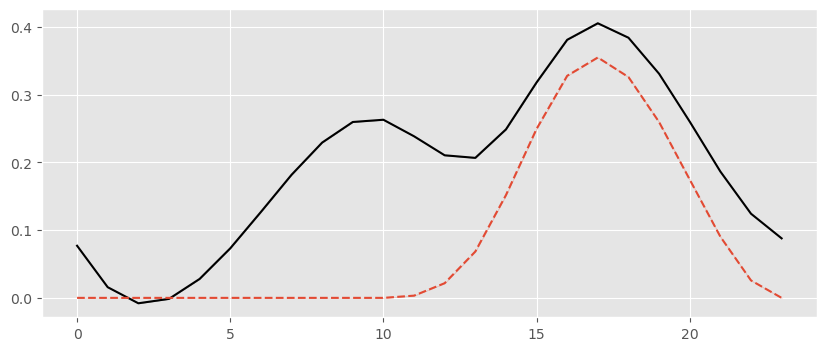

In [17]:
sns.lineplot(
    x=hour_bikes.flatten(), y=splines_predictive['mu'].mean(axis=0).T.flatten(),
    color='black'
    )
sns.lineplot(
    x=hour_bikes.flatten(), y=(B * spline_samples['beta'].mean(axis=0))[:, 5],
    linestyle='--'
    );

In [ ]:
cnt_mu = splines_predictive['y'].mean(axis=0).T.flatten()
cnt_std = splines_predictive['y'].std(axis=0).T.flatten()

df = pd.DataFrame({
    'hr': hour['hr'].values,
    'cnt_scaled': hour['cnt_std'].values,
    'cnt_mu': cnt_mu,
    'cnt_std': cnt_std,
    'cnt_high': cnt_mu + cnt_std,
    'cnt_low': cnt_mu - cnt_std
})

df = df.sort_values(by=['hr'])

### Figure 5.9

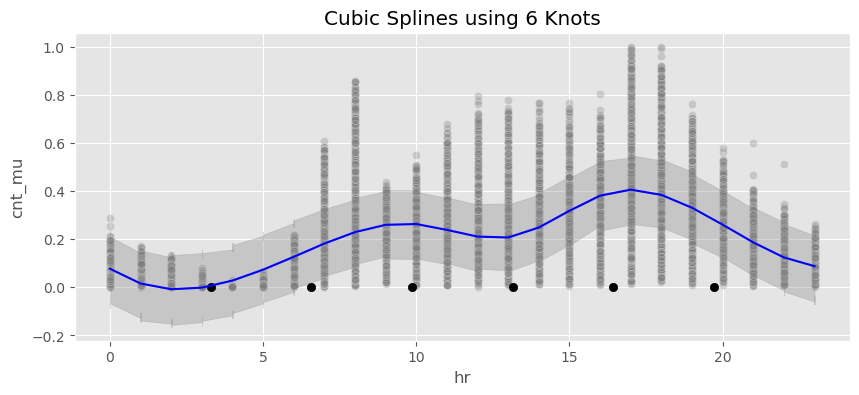

In [19]:
sns.lineplot(
    x=df['hr'], y=df['cnt_mu'], color='blue')
sns.scatterplot(
    x=hour['hr'], y=hour['cnt_std'], color='grey', alpha=0.3
    )
plt.fill_between(
    x=df['hr'], y1=df['cnt_high'], y2=df['cnt_low'], color='grey',
    alpha=0.3
    )
plt.scatter(knot_list, np.zeros_like(knot_list), color='black')
plt.title('Cubic Splines using 6 Knots');

## 5.6 - Choosing knots and priors for splines

In [59]:
Bs = []
num_knots = [3, 6, 9, 12, 18]
for nk in num_knots:
    knot_list = torch.linspace(0, 24, nk+2)[1:-1]
    B = dmatrix(
        'bs(cnt, knots=knots, degree=3, include_intercept=True) - 1',
        {'cnt': hour.hr.values, 'knots': knot_list[1:-1]}
    )
    B = torch.tensor(np.asarray(B)).float()
    Bs.append(B)

In [103]:
inf_data = []
for B in Bs:

    mcmc_obj = MCMC(NUTS(splines), 500, 300)
    mcmc_obj.run(B, cnt_bikes)

    post_samples = mcmc_obj.get_samples(500)
    post_pred = Predictive(
        splines, post_samples
    )(B, None)

    az_obj = az.from_pyro(
        posterior=mcmc_obj,
        posterior_predictive=post_pred
    )

    #inf_data.append(az_obj)

    inf_data.append(az.loo(az_obj, var_name='y'))

Sample: 100%|██████████| 800/800 [00:16, 48.42it/s, step size=2.96e-01, acc. prob=0.865]


In [115]:
dict_cmp = {f"m_{k}k": v for k, v in zip(num_knots, inf_data)}
cmp = az.compare(dict_cmp, ic='loo')

InvalidIndexError: slice(None, None, None)

In [114]:
dict_cmp['m_3k']

Computed from 500 posterior samples and 17379 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  8600.38   142.92
p_loo        6.03        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     17379  100.0%
 (0.5, 0.7]   (ok)           0    0.0%
   (0.7, 1]   (bad)          0    0.0%
   (1, Inf)   (very bad)     0    0.0%

### 5.6.1 Regularizing priors for splines